# [BAF507] Team Project 

# Members
- FMBA: Vania Estrellita Soegiarto(20214863), Olga Khegay(20214847)
- IMMBA: Sujin Cho(20224189) Myokyung Han(20224230), Yunho Park(20224020)

## 1. Load Library and Data

In [1]:
!pip install dmba

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
# library for feature selection package
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from dmba import regressionSummary

no display found. Using non-interactive Agg backend


In [3]:
# library for data processing package
import pandas as pd
import numpy as np

# library for standardization data processing package
from sklearn.preprocessing import StandardScaler

# library for dealing time-serise data processing package
from pandas.tseries.offsets import YearEnd

# library for image processing package
import seaborn as sns

# library for linear modeling package
import statsmodels.api as sm
%matplotlib inline

In [4]:
dfs = []

### 1.1) load deepsearch data

In [5]:
def load_deepsearch_data(filepath, column):
    df = pd.read_excel(filepath)
    if '날짜' in df.columns:
            df['날짜'] = pd.to_datetime(df['날짜'])
            df = df.set_index('날짜')
    elif 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')
    else :
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
    df.columns = [column]
    
    return df

In [6]:
deepsearch_filenames = [
    'krw_cad_xr',
    'current_account_korea', 'current_account_canada',
    'gdp_korea', 'gdp_canada',
    'gdp_growth_korea', 'gdp_growth_canada',
    'cpi_korea', 'cpi_canada',
    'int_rate_korea', 
    'foreign_reserves'
]

In [7]:
for fname in deepsearch_filenames:
    print('Loading {}...'.format(fname))
    filepath = f'./proj_data/{fname}.xlsx'       
    df = load_deepsearch_data(filepath, fname)

    if fname in ['gdp_growth_korea', 'gdp_growth_canada', 'current_account_canada']:
        df[fname] = df[fname].rolling(4).sum()
    elif fname in ['current_account_korea']:
        df[fname] = df[fname].rolling(12).sum()

    dfs.append(df)
    
print('Deepsearch Data loading is completed')

Loading krw_cad_xr...
Loading current_account_korea...
Loading current_account_canada...
Loading gdp_korea...
Loading gdp_canada...
Loading gdp_growth_korea...
Loading gdp_growth_canada...
Loading cpi_korea...
Loading cpi_canada...
Loading int_rate_korea...
Loading foreign_reserves...
Deepsearch Data loading is completed


### 1.2) load world bank data

In [8]:
def load_world_bank_data(filepath, column, nation):
    df = pd.read_excel(filepath, sheet_name = 'Data', skiprows = 3)
    df = df.set_index('Country Code')
    df = df.loc[nation].to_frame()
    df = df.iloc[3:]
    df.dropna(inplace=True)
    df[nation] = df[nation].astype(float)
    df['date'] = pd.to_datetime(df.index)+YearEnd(0)
    df.set_index('date', inplace=True)
    df.columns = [column]
    dfs.append(df) 

In [9]:
load_world_bank_data('./proj_data/world_real_xr.xls',  'krw_real_xr', 'KOR')
load_world_bank_data('./proj_data/world_real_xr.xls',  'cad_real_xr', 'CAN')
load_world_bank_data('./proj_data/world_ppp_xr.xls',   'krw_ppp_xr', 'KOR')
load_world_bank_data('./proj_data/world_ppp_xr.xls',   'cad_ppp_xr', 'CAN')

### 1.3) load other data

In [10]:
def load_other_data(filepath, column):
    df = pd.read_excel(filepath)
    if '날짜' in df.columns:
            df['날짜'] = pd.to_datetime(df['날짜'])
            df = df.set_index('날짜')
    elif 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.set_index('Date')
    else :
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
    df.columns = [column]
    
    return df

In [11]:
other_filenames = [
    'gold_price',
    'WTI_monthly',
    'trade_exim', 
    'int_rate_canada'
]

In [12]:
for fname in other_filenames:
    print('Loading {}...'.format(fname))
    filepath = f'./proj_data/{fname}.xlsx'
    df = pd.DataFrame()
    
    if fname in ['int_rate_canada'] :
        df = pd.read_excel(filepath, skiprows=14)
        df.dropna(axis=1, inplace=True)
        df.sort_values(by='Date', ascending=True, inplace=True)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        df = df.loc['1998-12-31':]
        df.columns = ['int_rate_canada']
        
    elif fname in ['WTI_monthly'] :
        df = pd.read_excel(filepath, skiprows = 2)
        df = df.set_index('Date')
        df.columns = ['oil_price']

                
    elif fname in ['trade_exim'] :
        df = pd.read_excel(filepath, skiprows = 4)
        df = df.drop(0)
        df['PRIOD'] = pd.to_datetime(df['PRIOD'])
        # rawdata 내 'PRIOD'는 Period를 의미함
        df = df.set_index('PRIOD')
        df['trade_balance'] = df['Trade Balance'].str.replace(',','')
        df = df['trade_balance'].astype(float)
    else :      
        df = load_other_data(filepath, fname)

        
    dfs.append(df)
    
print('Other Data loading is completed')

Loading gold_price...
Loading WTI_monthly...
Loading trade_exim...
Loading int_rate_canada...
Other Data loading is completed


### 1.4) merge whole data

In [13]:
df_merged = pd.concat(dfs, axis = 1)

In [14]:
df_merged.columns

Index(['krw_cad_xr', 'current_account_korea', 'current_account_canada',
       'gdp_korea', 'gdp_canada', 'gdp_growth_korea', 'gdp_growth_canada',
       'cpi_korea', 'cpi_canada', 'int_rate_korea', 'foreign_reserves',
       'krw_real_xr', 'cad_real_xr', 'krw_ppp_xr', 'cad_ppp_xr', 'gold_price',
       'oil_price', 'trade_balance', 'int_rate_canada'],
      dtype='object')

In [15]:
df_merged.head()

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,foreign_reserves,krw_real_xr,cad_real_xr,krw_ppp_xr,cad_ppp_xr,gold_price,oil_price,trade_balance,int_rate_canada
1946-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,NaN,NaN
1946-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,NaN,NaN
1946-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,NaN,NaN
1946-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,NaN,NaN
1946-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.71,NaN,NaN,NaN


In [16]:
df_merged = df_merged.resample('M').last()

In [17]:
df_merged = df_merged.fillna(method='ffill')

In [18]:
df_merged.columns

Index(['krw_cad_xr', 'current_account_korea', 'current_account_canada',
       'gdp_korea', 'gdp_canada', 'gdp_growth_korea', 'gdp_growth_canada',
       'cpi_korea', 'cpi_canada', 'int_rate_korea', 'foreign_reserves',
       'krw_real_xr', 'cad_real_xr', 'krw_ppp_xr', 'cad_ppp_xr', 'gold_price',
       'oil_price', 'trade_balance', 'int_rate_canada'],
      dtype='object')

## 2. Data Preprocessing

### 2.1) Data Preprocessing for Currency Returns

In [19]:
df_merged['ann_ret'] = df_merged['krw_cad_xr'].pct_change(periods=12)*100

In [20]:
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

In [21]:
df_merged['2010-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,krw_real_xr,cad_real_xr,krw_ppp_xr,cad_ppp_xr,gold_price,oil_price,trade_balance,int_rate_canada,ann_ret,F12.ann_ret
2010-12-31,1138.67,27950.5,-58162.67,1144067.0,1617345.3,6.3,3.5,101.02,100.89,2.890,...,0.727463,1.186103,840.991702,1.221820,1421.40,89.15,-68731.0,3.117,2.861814,-0.784248
2011-01-31,1112.74,26567.3,-58162.67,1144067.0,1617345.3,6.3,3.5,102.22,101.14,3.330,...,0.727463,1.186103,840.991702,1.221820,1332.68,89.17,-48406.0,3.274,2.638982,0.920251
2011-02-28,1153.98,28234.6,-58162.67,1144067.0,1617345.3,5.2,3.5,102.92,101.40,3.400,...,0.727463,1.186103,840.991702,1.221820,1411.33,88.58,-155998.0,3.302,5.635195,-1.896047
2011-03-31,1139.62,24879.2,-57252.88,1144067.0,1617345.3,5.2,3.1,103.32,102.52,3.420,...,0.727463,1.186103,840.991702,1.221820,1432.20,102.86,-21830.0,3.353,2.704554,0.160580
2011-04-30,1128.32,21537.1,-57252.88,1144067.0,1617345.3,5.2,3.1,103.42,102.86,3.480,...,0.727463,1.186103,840.991702,1.221820,1563.70,109.53,-151483.0,3.213,1.533367,2.478907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,0.698660,0.928844,824.604924,1.245722,1829.20,71.71,134851.0,1.430,9.060120,NaN
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,0.698660,0.928844,824.604924,1.245722,1797.17,83.22,106536.0,1.770,8.644618,NaN
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,0.698660,0.928844,824.604924,1.245722,1908.99,91.64,15529.0,1.849,7.253267,NaN
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,0.698660,0.928844,824.604924,1.245722,1908.99,108.50,15529.0,2.401,8.068217,NaN


### 2.2) Data Preprocessing for PPP XR

$$
    \text{PPP XR} = \frac{\frac{{P(KRW)}}{P(USD)}} {\frac{{P(CAD)}}{P(USD)}} = \frac{{P(KRW)}}{P(CAD)}
$$

In [22]:
df_merged['krw_cad_ppp_xr'] = df_merged['krw_ppp_xr']/ df_merged['cad_ppp_xr']

### 2.3) Data Preprocessing for KRW_CAD_REAL_XR

In [23]:
# world bank의 real XR 기준으로 KRW/CAD의 real XR 계산 >> KRW_CAD_REAL_XR
# 추후 계산할 New Real XR의 Validation을 위한 Data Preprocessing
df_merged['krw_cad_real_xr'] = df_merged['krw_real_xr']/df_merged['cad_real_xr']

In [24]:
df_merged.loc[['2009-12-31']]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,krw_ppp_xr,cad_ppp_xr,gold_price,oil_price,trade_balance,int_rate_canada,ann_ret,F12.ann_ret,krw_cad_ppp_xr,krw_cad_real_xr
2009-12-31,1106.99,33087.6,-40775.27,943941.9,1376509.2,5.1,-1.8,98.04,98.57,3.48,...,828.420848,1.202244,1096.98,74.47,16663.0,3.615,6.614595,2.861814,689.06216,0.616844


In [25]:
df_merged['krw_cad_ppp_xr'] = df_merged['krw_cad_ppp_xr'].fillna(method='ffill')
df_merged['krw_cad_real_xr'] = df_merged['krw_cad_real_xr'].fillna(method='ffill')

In [26]:
df_merged['2010-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,krw_ppp_xr,cad_ppp_xr,gold_price,oil_price,trade_balance,int_rate_canada,ann_ret,F12.ann_ret,krw_cad_ppp_xr,krw_cad_real_xr
2010-12-31,1138.67,27950.5,-58162.67,1144067.0,1617345.3,6.3,3.5,101.02,100.89,2.890,...,840.991702,1.221820,1421.40,89.15,-68731.0,3.117,2.861814,-0.784248,688.310637,0.613322
2011-01-31,1112.74,26567.3,-58162.67,1144067.0,1617345.3,6.3,3.5,102.22,101.14,3.330,...,840.991702,1.221820,1332.68,89.17,-48406.0,3.274,2.638982,0.920251,688.310637,0.613322
2011-02-28,1153.98,28234.6,-58162.67,1144067.0,1617345.3,5.2,3.5,102.92,101.40,3.400,...,840.991702,1.221820,1411.33,88.58,-155998.0,3.302,5.635195,-1.896047,688.310637,0.613322
2011-03-31,1139.62,24879.2,-57252.88,1144067.0,1617345.3,5.2,3.1,103.32,102.52,3.420,...,840.991702,1.221820,1432.20,102.86,-21830.0,3.353,2.704554,0.160580,688.310637,0.613322
2011-04-30,1128.32,21537.1,-57252.88,1144067.0,1617345.3,5.2,3.1,103.42,102.86,3.480,...,840.991702,1.221820,1563.70,109.53,-151483.0,3.213,1.533367,2.478907,688.310637,0.613322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,824.604924,1.245722,1829.20,71.71,134851.0,1.430,9.060120,NaN,661.949395,0.752182
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,824.604924,1.245722,1797.17,83.22,106536.0,1.770,8.644618,NaN,661.949395,0.752182
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,824.604924,1.245722,1908.99,91.64,15529.0,1.849,7.253267,NaN,661.949395,0.752182
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,824.604924,1.245722,1908.99,108.50,15529.0,2.401,8.068217,NaN,661.949395,0.752182


### 2.4) Data Preprocessing for New Real XR

$$
    \text{Real XR} = \frac{S^{PPP}}{S}
$$

In [27]:
## New Real XR calculate
df_merged['new_real_xr'] = \
    df_merged['krw_cad_ppp_xr']/df_merged['krw_cad_xr']

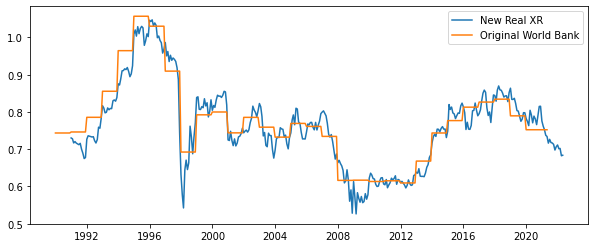

In [28]:
# let's draw a gragh with New Real XR and Original World Bank data
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,4)

plt.plot(df_merged['new_real_xr'], label = 'New Real XR')
plt.plot(df_merged['krw_cad_real_xr'].shift(-12), label = 'Original World Bank')
plt.legend()
plt.show()

In [29]:
df_merged['2010-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,cad_ppp_xr,gold_price,oil_price,trade_balance,int_rate_canada,ann_ret,F12.ann_ret,krw_cad_ppp_xr,krw_cad_real_xr,new_real_xr
2010-12-31,1138.67,27950.5,-58162.67,1144067.0,1617345.3,6.3,3.5,101.02,100.89,2.890,...,1.221820,1421.40,89.15,-68731.0,3.117,2.861814,-0.784248,688.310637,0.613322,0.604486
2011-01-31,1112.74,26567.3,-58162.67,1144067.0,1617345.3,6.3,3.5,102.22,101.14,3.330,...,1.221820,1332.68,89.17,-48406.0,3.274,2.638982,0.920251,688.310637,0.613322,0.618573
2011-02-28,1153.98,28234.6,-58162.67,1144067.0,1617345.3,5.2,3.5,102.92,101.40,3.400,...,1.221820,1411.33,88.58,-155998.0,3.302,5.635195,-1.896047,688.310637,0.613322,0.596467
2011-03-31,1139.62,24879.2,-57252.88,1144067.0,1617345.3,5.2,3.1,103.32,102.52,3.420,...,1.221820,1432.20,102.86,-21830.0,3.353,2.704554,0.160580,688.310637,0.613322,0.603983
2011-04-30,1128.32,21537.1,-57252.88,1144067.0,1617345.3,5.2,3.1,103.42,102.86,3.480,...,1.221820,1563.70,109.53,-151483.0,3.213,1.533367,2.478907,688.310637,0.613322,0.610031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,1.245722,1829.20,71.71,134851.0,1.430,9.060120,NaN,661.949395,0.752182,0.711307
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,1.245722,1797.17,83.22,106536.0,1.770,8.644618,NaN,661.949395,0.752182,0.701143
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,1.245722,1908.99,91.64,15529.0,1.849,7.253267,NaN,661.949395,0.752182,0.701991
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,1.245722,1908.99,108.50,15529.0,2.401,8.068217,NaN,661.949395,0.752182,0.682317


### 2.5) Data Preprocessing for Current Account relative to GDP

In [30]:
df_merged['ca_gdp_korea'] = df_merged['current_account_korea']/df_merged['gdp_korea']*100

In [31]:
df_merged['ca_gdp_canada'] = df_merged['current_account_canada']/df_merged['gdp_canada']*100

In [32]:
df_merged['2010-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,oil_price,trade_balance,int_rate_canada,ann_ret,F12.ann_ret,krw_cad_ppp_xr,krw_cad_real_xr,new_real_xr,ca_gdp_korea,ca_gdp_canada
2010-12-31,1138.67,27950.5,-58162.67,1144067.0,1617345.3,6.3,3.5,101.02,100.89,2.890,...,89.15,-68731.0,3.117,2.861814,-0.784248,688.310637,0.613322,0.604486,2.443082,-3.596181
2011-01-31,1112.74,26567.3,-58162.67,1144067.0,1617345.3,6.3,3.5,102.22,101.14,3.330,...,89.17,-48406.0,3.274,2.638982,0.920251,688.310637,0.613322,0.618573,2.322180,-3.596181
2011-02-28,1153.98,28234.6,-58162.67,1144067.0,1617345.3,5.2,3.5,102.92,101.40,3.400,...,88.58,-155998.0,3.302,5.635195,-1.896047,688.310637,0.613322,0.596467,2.467915,-3.596181
2011-03-31,1139.62,24879.2,-57252.88,1144067.0,1617345.3,5.2,3.1,103.32,102.52,3.420,...,102.86,-21830.0,3.353,2.704554,0.160580,688.310637,0.613322,0.603983,2.174628,-3.539929
2011-04-30,1128.32,21537.1,-57252.88,1144067.0,1617345.3,5.2,3.1,103.42,102.86,3.480,...,109.53,-151483.0,3.213,1.533367,2.478907,688.310637,0.613322,0.610031,1.882503,-3.539929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,71.71,134851.0,1.430,9.060120,NaN,661.949395,0.752182,0.711307,5.518208,-0.063136
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,83.22,106536.0,1.770,8.644618,NaN,661.949395,0.752182,0.701143,5.197730,-0.063136
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,91.64,15529.0,1.849,7.253267,NaN,661.949395,0.752182,0.701991,5.197730,-0.063136
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,108.50,15529.0,2.401,8.068217,NaN,661.949395,0.752182,0.682317,5.197730,-0.063136


In [33]:
df_merged.loc['2009-12-31':][['ca_gdp_korea', 'ca_gdp_canada']].head()

,ca_gdp_korea,ca_gdp_canada
2009-12-31,3.505258,-2.962223
2010-01-31,3.298445,-2.962223
2010-02-28,2.733219,-2.962223
2010-03-31,2.217414,-3.442037
2010-04-30,1.969274,-3.442037


### 2.6) Data Preprocessing for GDP Growth

In [34]:
df_merged['gdp_growth_korea2'] = df_merged['gdp_korea'].pct_change(periods=12)*100

In [35]:
df_merged['gdp_growth_canada2'] = df_merged['gdp_canada'].pct_change(periods=12)*100

In [36]:
df_merged['2010-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,int_rate_canada,ann_ret,F12.ann_ret,krw_cad_ppp_xr,krw_cad_real_xr,new_real_xr,ca_gdp_korea,ca_gdp_canada,gdp_growth_korea2,gdp_growth_canada2
2010-12-31,1138.67,27950.5,-58162.67,1144067.0,1617345.3,6.3,3.5,101.02,100.89,2.890,...,3.117,2.861814,-0.784248,688.310637,0.613322,0.604486,2.443082,-3.596181,21.200998,17.496149
2011-01-31,1112.74,26567.3,-58162.67,1144067.0,1617345.3,6.3,3.5,102.22,101.14,3.330,...,3.274,2.638982,0.920251,688.310637,0.613322,0.618573,2.322180,-3.596181,21.200998,17.496149
2011-02-28,1153.98,28234.6,-58162.67,1144067.0,1617345.3,5.2,3.5,102.92,101.40,3.400,...,3.302,5.635195,-1.896047,688.310637,0.613322,0.596467,2.467915,-3.596181,21.200998,17.496149
2011-03-31,1139.62,24879.2,-57252.88,1144067.0,1617345.3,5.2,3.1,103.32,102.52,3.420,...,3.353,2.704554,0.160580,688.310637,0.613322,0.603983,2.174628,-3.539929,21.200998,17.496149
2011-04-30,1128.32,21537.1,-57252.88,1144067.0,1617345.3,5.2,3.1,103.42,102.86,3.480,...,3.213,1.533367,2.478907,688.310637,0.613322,0.610031,1.882503,-3.539929,21.200998,17.496149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,1.430,9.060120,NaN,661.949395,0.752182,0.711307,5.518208,-0.063136,0.000000,0.000000
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,1.770,8.644618,NaN,661.949395,0.752182,0.701143,5.197730,-0.063136,0.000000,0.000000
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,1.849,7.253267,NaN,661.949395,0.752182,0.701991,5.197730,-0.063136,0.000000,0.000000
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,2.401,8.068217,NaN,661.949395,0.752182,0.682317,5.197730,-0.063136,0.000000,0.000000


In [37]:
df_merged.loc[['2018-12-31', '2019-12-31']][['gdp_canada', 'gdp_growth_korea2','gdp_growth_canada2']]

,gdp_canada,gdp_growth_korea2,gdp_growth_canada2
2018-12-31,1716179.4,5.953397,4.034536
2019-12-31,1736346.3,-4.556310,1.175104


### 2.7) Data Preprocessing for Inflation & Interest rate differential

In [38]:
df_merged['infl_korea'] = df_merged['cpi_korea'].pct_change(periods=12) *100

In [39]:
df_merged['infl_canada'] = df_merged['cpi_canada'].pct_change(periods=12) *100

In [40]:
df_merged['infl_diff'] = df_merged['infl_korea']- df_merged['infl_canada']

In [41]:
df_merged['int_rate_diff'] = df_merged['int_rate_korea']- df_merged['int_rate_canada']

In [42]:
df_merged['2008-12-31':]

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,krw_cad_real_xr,new_real_xr,ca_gdp_korea,ca_gdp_canada,gdp_growth_korea2,gdp_growth_canada2,infl_korea,infl_canada,infl_diff,int_rate_diff
2008-12-31,1038.31,1753.0,3177.94,1047339.0,1552864.1,-1.6,0.1,95.37,97.28,3.260,...,0.616281,0.613038,0.167377,0.204650,-10.683404,5.71643,4.138458,1.164725,2.973733,0.572
2009-01-31,1116.50,2617.5,3177.94,1047339.0,1552864.1,-1.6,0.1,95.46,97.02,2.530,...,0.616281,0.570106,0.249919,0.204650,-10.683404,5.71643,3.749592,1.073028,2.676564,-0.534
2009-02-28,1209.49,9865.7,3177.94,1047339.0,1552864.1,-1.9,0.1,96.15,97.71,2.540,...,0.616281,0.526274,0.941978,0.204650,-10.683404,5.71643,4.103508,1.422047,2.681461,-0.592
2009-03-31,1091.38,14679.2,-6845.27,1047339.0,1552864.1,-1.9,-2.3,96.84,97.88,2.700,...,0.616281,0.583228,1.401571,-0.440816,-10.683404,5.71643,3.883287,1.241208,2.642079,-0.080
2009-04-30,1119.83,20204.9,-6845.27,1047339.0,1552864.1,-1.9,-2.3,97.09,97.80,2.530,...,0.616281,0.568411,1.929165,-0.440816,-10.683404,5.71643,3.573715,0.359159,3.214556,-0.564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31,930.61,90382.5,-1038.86,1637895.8,1645423.4,3.7,3.9,120.45,123.64,1.350,...,0.752182,0.711307,5.518208,-0.063136,0.000000,0.00000,3.782526,4.806307,-1.023780,-0.080
2022-01-31,944.10,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,124.76,1.463,...,0.752182,0.701143,5.197730,-0.063136,0.000000,0.00000,3.660310,5.140738,-1.480429,-0.307
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,0.752182,0.701991,5.197730,-0.063136,0.000000,0.00000,3.139891,5.685058,-2.545167,-0.346
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,0.752182,0.682317,5.197730,-0.063136,0.000000,0.00000,2.990908,5.156015,-2.165107,-0.586


### 2.8) Data Preprocessing for Foreign Reserves

In [43]:
df_merged['reserves_to_gdp'] = df_merged['foreign_reserves']/df_merged['gdp_korea']/1000*100
df_merged['reserves_growth'] = df_merged['foreign_reserves'].pct_change(periods=12)*100

### 2.9) Data Preprocessing for Gold Price

In [44]:
#price보다 growth가 점수가 더 좋은 것을 확인 후 pct_change로 결정
df_merged['gold_growth'] = df_merged['gold_price'].pct_change(periods=12) * 100

### 2.11) Data Preprocessing for Trade Balance

In [45]:
df_merged['trade_balance_growth'] = df_merged['trade_balance'].pct_change(periods=12)*100

In [46]:
#Scaling for trade balance data
ss = StandardScaler() 
df_merged['trade_balance_scaled'] = ss.fit_transform(df_merged[['trade_balance']])                

In [47]:
df_merged['trade_balance_scaled'].max()

6.505067678656895

### 2.12) Data Preprocessing for Oil Price

In [48]:
df_merged['oil_growth'] = df_merged['oil_price'].pct_change(periods=12) * 100
df_merged['oil_growth'] = df_merged['oil_price'].pct_change(periods=12) * 100

## 3. Use OLS

### 3.1) Dataset slicing for better prediction

In [49]:
# 금융위기 이전을 포함할 경우 예측력이 낮아져서 금융위기 이후로 설정
dataset = df_merged.loc['2008-12-31':].copy()

In [50]:
dataset.head()

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,infl_korea,infl_canada,infl_diff,int_rate_diff,reserves_to_gdp,reserves_growth,gold_growth,trade_balance_growth,trade_balance_scaled,oil_growth
2008-12-31,1038.31,1753.0,3177.94,1047339.0,1552864.1,-1.6,0.1,95.37,97.28,3.26,...,4.138458,1.164725,2.973733,0.572,19.212825,-23.262798,5.799448,218.682483,-1.074466,-55.153234
2009-01-31,1116.50,2617.5,3177.94,1047339.0,1552864.1,-1.6,0.1,95.46,97.02,2.53,...,3.749592,1.073028,2.676564,-0.534,19.262245,-22.961608,0.188964,15.799194,-0.597777,-55.136065
2009-02-28,1209.49,9865.7,3177.94,1047339.0,1552864.1,-1.9,0.1,96.15,97.71,2.54,...,4.103508,1.422047,2.681461,-0.592,19.242540,-23.185343,-3.242633,-69.195706,-0.273819,-59.020862
2009-03-31,1091.38,14679.2,-6845.27,1047339.0,1552864.1,-1.9,-2.3,96.84,97.88,2.70,...,3.883287,1.241208,2.642079,-0.080,19.701403,-21.913389,0.267205,6.984096,-0.483338,-54.537696
2009-04-30,1119.83,20204.9,-6845.27,1047339.0,1552864.1,-1.9,-2.3,97.09,97.80,2.53,...,3.573715,0.359159,3.214556,-0.564,20.287416,-18.429075,1.213606,-207.553693,-0.563960,-55.898028


In [51]:
X_cols = ['new_real_xr', 
          'ca_gdp_korea', 'ca_gdp_canada',
          'gdp_growth_korea', 'gdp_growth_canada', 
          'infl_diff', 'int_rate_diff', 
          'reserves_to_gdp' , 'reserves_growth',
          'gold_growth', 'oil_growth',
          'trade_balance_growth', 'trade_balance_scaled']

In [52]:
dataset[['F12.ann_ret', *X_cols]].loc['2008-12-31':].head(15)

,F12.ann_ret,new_real_xr,ca_gdp_korea,ca_gdp_canada,gdp_growth_korea,gdp_growth_canada,infl_diff,int_rate_diff,reserves_to_gdp,reserves_growth,gold_growth,oil_growth,trade_balance_growth,trade_balance_scaled
2008-12-31,6.614595,0.613038,0.167377,0.204650,-1.6,0.1,2.973733,0.572,19.212825,-23.262798,5.799448,-55.153234,218.682483,-1.074466
2009-01-31,-2.899239,0.570106,0.249919,0.204650,-1.6,0.1,2.676564,-0.534,19.262245,-22.961608,0.188964,-55.136065,15.799194,-0.597777
2009-02-28,-9.679286,0.526274,0.941978,0.204650,-1.9,0.1,2.681461,-0.592,19.242540,-23.185343,-3.242633,-59.020862,-69.195706,-0.273819
2009-03-31,1.670362,0.583228,1.401571,-0.440816,-1.9,-2.3,2.642079,-0.080,19.701403,-21.913389,0.267205,-54.537696,6.984096,-0.483338
2009-04-30,-0.763509,0.568411,1.929165,-0.440816,-1.9,-2.3,3.214556,-0.564,20.287416,-18.429075,1.213606,-55.898028,-207.553693,-0.563960
2009-05-31,-0.311895,0.557664,2.317502,-0.440816,-1.1,-2.3,2.648569,-0.960,21.651663,-12.173810,10.454597,-52.926635,-239.682850,0.818262
2009-06-30,3.408477,0.573052,2.814733,-1.394095,-1.1,-3.8,2.250008,-0.417,22.126038,-10.214477,0.118868,-47.983269,-118.369197,-0.039037
2009-07-31,0.237739,0.556348,3.220466,-1.394095,-1.1,-3.8,2.573400,-0.679,22.677442,-4.045276,4.364949,-51.900727,198.105911,-0.825981
2009-08-31,-1.391624,0.559571,3.699261,-1.394095,1.1,-3.8,2.950408,0.049,23.436398,0.928549,14.442640,-39.101740,-19.707333,-0.845704
2009-09-30,0.910434,0.580674,3.768827,-2.449797,1.1,-4.2,3.017824,0.230,24.275545,6.081427,15.701246,-33.330132,-76.565611,-0.375162


In [53]:
df = dataset[['F12.ann_ret', *X_cols]].copy()
df = df.dropna()

In [54]:
X_data = df[X_cols].copy()
Y = df['F12.ann_ret']

### 3.2) Check correlation between variables

In [55]:
df_corr = X_data.corr()

In [56]:
def onetozero(x):
#     print(x)
    return np.where(x==1, 0, x)

In [57]:
df_corr = df_corr.apply(lambda x: onetozero(x))

In [58]:
# corr이 가장 높은 컬럼
print(df_corr.max().sort_values(ascending=False).index[0])
print(df_corr[df_corr.max().sort_values(ascending=False).index[0]].idxmax())

reserves_to_gdp
reserves_growth


In [59]:
# corr이 두번째로 높은 컬럼
print(df_corr.max().sort_values(ascending=False).index[1])
print(df_corr[df_corr.max().sort_values(ascending=False).index[1]].idxmax())

reserves_growth
reserves_to_gdp


In [60]:
# corr이 세번째로 높은 컬럼
print(df_corr.max().sort_values(ascending=False).index[2])
print(df_corr[df_corr.max().sort_values(ascending=False).index[2]].idxmax())

new_real_xr
ca_gdp_korea


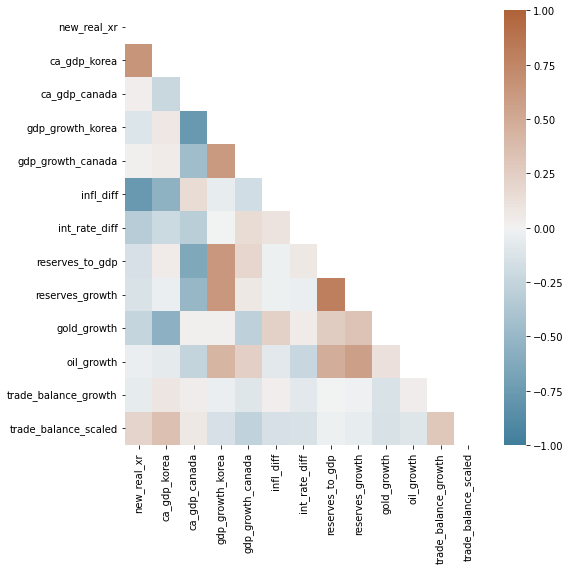

In [61]:
mask = np.triu(np.ones_like(df_corr, dtype=bool))
cmap = sns.diverging_palette(230, 30, as_cmap=True)
plt.rcParams['figure.figsize']  = (8, 8)
sns.heatmap(df_corr, cmap=cmap, mask = mask, vmin=-1, vmax=1)
plt.show()

### 3.3) Use forward_selection/backward_selection  package to choose variables

In [62]:
def train_model(variables):
    if len(variables) == 0: 
        return None
    model = LinearRegression() 
    model.fit(X_data[variables], Y)
    return model

def score_model(model, variables): 
    if len(variables) == 0:
        return AIC_score(Y, [Y.mean()] * len(Y), model, df=1)
    return AIC_score(Y, model.predict(X_data[variables]), model)

foward_best_model, foward_best_variables = forward_selection(X_cols, train_model,score_model, verbose=True)
regressionSummary(Y, foward_best_model.predict(X_data[foward_best_variables]))


Variables: new_real_xr, ca_gdp_korea, ca_gdp_canada, gdp_growth_korea, gdp_growth_canada, infl_diff, int_rate_diff, reserves_to_gdp, reserves_growth, gold_growth, oil_growth, trade_balance_growth, trade_balance_scaled
Start: score=935.45, constant
Step: score=909.82, add gold_growth
Step: score=872.55, add new_real_xr
Step: score=857.89, add infl_diff
Step: score=850.16, add ca_gdp_canada
Step: score=842.94, add oil_growth
Step: score=841.83, add gdp_growth_canada
Step: score=837.75, add ca_gdp_korea
Step: score=836.49, add reserves_to_gdp
Step: score=836.49, add None

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 3.7470
            Mean Absolute Error (MAE) : 3.1386
          Mean Percentage Error (MPE) : 72.6538
Mean Absolute Percentage Error (MAPE) : 136.4457


In [63]:
def train_model(variables):
    model = LinearRegression() 
    model.fit(X_data[variables], Y) 
    return model

def score_model(model, variables):
    return AIC_score(Y, model.predict(X_data[variables]), model)

allVariables = X_cols
backward_best_model, backward_best_variables = backward_elimination(allVariables, train_model,score_model, verbose=True) 
regressionSummary(Y, backward_best_model.predict(X_data[backward_best_variables]))

Variables: new_real_xr, ca_gdp_korea, ca_gdp_canada, gdp_growth_korea, gdp_growth_canada, infl_diff, int_rate_diff, reserves_to_gdp, reserves_growth, gold_growth, oil_growth, trade_balance_growth, trade_balance_scaled
Start: score=843.38
Step: score=841.39, remove gdp_growth_korea
Step: score=839.49, remove trade_balance_scaled
Step: score=837.73, remove reserves_growth
Step: score=836.92, remove trade_balance_growth
Step: score=836.49, remove int_rate_diff
Step: score=836.49, remove None

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 3.7470
            Mean Absolute Error (MAE) : 3.1386
          Mean Percentage Error (MPE) : 72.6538
Mean Absolute Percentage Error (MAPE) : 136.4457


In [64]:
# 위 결과에서 유의미한 변수 넣기
selected_col = ['new_real_xr', 
              'ca_gdp_korea', 'ca_gdp_canada',
              'gdp_growth_canada', 
              'infl_diff', 
              'reserves_to_gdp' , 
              'gold_growth', 'oil_growth',
                ]

In [65]:
final_df = dataset[['F12.ann_ret', *selected_col]].copy()
final_df = df.dropna()

### 3.4) OLS(Ordinary Least Square) Regression

In [66]:
df_X = final_df[selected_col].copy()
df_Y = final_df['F12.ann_ret']

In [67]:
df_X.head()

,new_real_xr,ca_gdp_korea,ca_gdp_canada,gdp_growth_canada,infl_diff,reserves_to_gdp,gold_growth,oil_growth
2008-12-31,0.613038,0.167377,0.204650,0.1,2.973733,19.212825,5.799448,-55.153234
2009-01-31,0.570106,0.249919,0.204650,0.1,2.676564,19.262245,0.188964,-55.136065
2009-02-28,0.526274,0.941978,0.204650,0.1,2.681461,19.242540,-3.242633,-59.020862
2009-03-31,0.583228,1.401571,-0.440816,-2.3,2.642079,19.701403,0.267205,-54.537696
2009-04-30,0.568411,1.929165,-0.440816,-2.3,3.214556,20.287416,1.213606,-55.898028


In [68]:
df_Y.head()

2008-12-31    6.614595
2009-01-31   -2.899239
2009-02-28   -9.679286
2009-03-31    1.670362
2009-04-30   -0.763509
Freq: M, Name: F12.ann_ret, dtype: float64

In [69]:
X = sm.add_constant(df_X)

/Users/boysbeanxious/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [70]:
Y = final_df['F12.ann_ret']

In [71]:
model = sm.OLS(Y,X)

In [72]:
results = model.fit()

In [73]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     20.35
Date:                Thu, 14 Apr 2022   Prob (F-statistic):           3.52e-20
Time:                        21:47:11   Log-Likelihood:                -408.25
No. Observations:                 149   AIC:                             834.5
Df Residuals:                     140   BIC:                             861.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -41.4121      7.713     -5.369      0.000     -56.660     -26.164
new_real_xr          48.6976      6.122      7.955      0.000      36.594      60.801
ca_gdp_korea         -0.9107      0.326     -2.790      0.006      -1.556      -0.265
ca_gdp_canada         1.2335      0.589      2.095      0.038       0.069       2.398
gdp_growth_canada    -0.3537      0.143     -2.472      0.015      -0.637      -0.071
infl_diff             1.5726      0.450      3.498      0.001       0.684       2.461
reserves_to_gdp       0.4627      0.263      1.760      0.081      -0.057       0.982
gold_growth           0.0898      0.029      3.050      0.003       0.032       0.148
oil_growth            0.0202      0.009      2.155      0.033       0.002       0.039
==============================================================================
Omnibus:                        6.374   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                3.937
Skew:                           0.219   Prob(JB):                        0.140
Kurtosis:                       2.335   Cond. No.                     1.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3.5) Results analysis

$$
y = \alpha + \beta x
$$

$$
\text{ret}_{t, t+12} = \alpha + \beta \, \text{Real XR}_t +\epsilon
$$

In [74]:
results.params

const               -41.412145
new_real_xr          48.697577
ca_gdp_korea         -0.910680
ca_gdp_canada         1.233505
gdp_growth_canada    -0.353705
infl_diff             1.572557
reserves_to_gdp       0.462729
gold_growth           0.089756
oil_growth            0.020196
dtype: float64

In [75]:
results.params

const               -41.412145
new_real_xr          48.697577
ca_gdp_korea         -0.910680
ca_gdp_canada         1.233505
gdp_growth_canada    -0.353705
infl_diff             1.572557
reserves_to_gdp       0.462729
gold_growth           0.089756
oil_growth            0.020196
dtype: float64

In [76]:
last_obs = dataset.iloc[-1]

In [77]:
last_obs

krw_cad_xr                9.680600e+02
current_account_korea     8.513340e+04
current_account_canada   -1.038860e+03
gdp_korea                 1.637896e+06
gdp_canada                1.645423e+06
gdp_growth_korea          3.700000e+00
gdp_growth_canada         3.900000e+00
cpi_korea                 1.212100e+02
cpi_canada                1.260400e+02
int_rate_korea            1.852000e+00
foreign_reserves          4.617663e+08
krw_real_xr               6.986604e-01
cad_real_xr               9.288443e-01
krw_ppp_xr                8.246049e+02
cad_ppp_xr                1.245722e+00
gold_price                1.908990e+03
oil_price                 1.085000e+02
trade_balance             1.552900e+04
int_rate_canada           2.401000e+00
ann_ret                   7.353479e+00
F12.ann_ret                        NaN
krw_cad_ppp_xr            6.619494e+02
krw_cad_real_xr           7.521824e-01
new_real_xr               6.837896e-01
ca_gdp_korea              5.197730e+00
ca_gdp_canada            

In [78]:
last_xr = last_obs['krw_cad_xr']
last_year_xr = last_obs['new_real_xr']

In [79]:
last_xr

968.06

In [80]:
last_year_xr

0.6837896357754619

In [81]:
import matplotlib.pyplot as plt

In [82]:
plt.rcParams['figure.figsize']  = (10, 4)

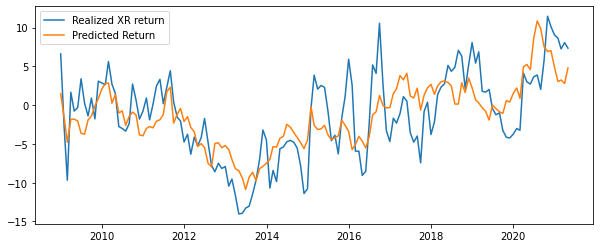

In [83]:
plt.plot(Y, label = 'Realized XR return')
plt.plot(Y.index, results.predict(), label='Predicted Return')
plt.legend()
plt.savefig(f'./Realized_Predicted2.jpg', dpi=300)
plt.show()

In [84]:
plt.rcParams['figure.figsize']  = (6, 6)

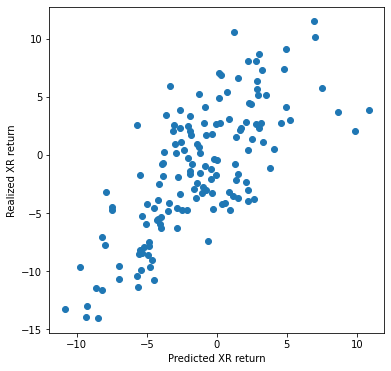

In [85]:
plt.scatter(results.predict(), Y)
plt.xlabel('Predicted XR return')
plt.ylabel('Realized XR return')
plt.show()

## 3.6) XR Forecast

In [86]:
dataset.tail(3)

,krw_cad_xr,current_account_korea,current_account_canada,gdp_korea,gdp_canada,gdp_growth_korea,gdp_growth_canada,cpi_korea,cpi_canada,int_rate_korea,...,infl_korea,infl_canada,infl_diff,int_rate_diff,reserves_to_gdp,reserves_growth,gold_growth,trade_balance_growth,trade_balance_scaled,oil_growth
2022-02-28,942.96,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.503,...,3.139891,5.685058,-2.545167,-0.346,28.192654,3.174745,10.089156,-89.648299,-0.010036,55.216802
2022-03-31,970.15,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.815,...,2.990908,5.156015,-2.165107,-0.586,28.192654,3.505480,11.786545,-85.216671,-0.010036,74.073480
2022-04-30,968.06,85133.4,-1038.86,1637895.8,1645423.4,3.7,3.9,121.21,126.04,1.852,...,2.772596,4.632243,-1.859647,-0.549,28.192654,2.090744,7.905581,-187.566257,-0.010036,75.793908


In [87]:
last_obs = dataset.iloc[-1]

In [88]:
last_xr = last_obs['krw_cad_xr']

In [89]:
last_xr

968.06

In [90]:
# exog = exogeneous variables
exog = last_obs[selected_col]

In [91]:
exog

new_real_xr           0.683790
ca_gdp_korea          5.197730
ca_gdp_canada        -0.063136
gdp_growth_canada     3.900000
infl_diff            -1.859647
reserves_to_gdp      28.192654
gold_growth           7.905581
oil_growth           75.793908
Name: 2022-04-30 00:00:00, dtype: float64

In [92]:
exog = [1, *exog]

In [93]:
exog

[1,
 0.6837896357754619,
 5.197729916640608,
 -0.06313633317722354,
 3.8999999999999995,
 -1.8596468328645255,
 28.192653830603874,
 7.905580709162119,
 75.79390797148413]

In [94]:
pred_ret = results.predict(exog=exog)

In [95]:
pred_xr = last_xr*(1+pred_ret[0]/100)

In [96]:
print('Predicted XR return : {:.2f}%'.format(pred_ret[0]))

Predicted XR return : -1.94%


In [97]:
print('Predicted XR {:.2f} to : {:.2f}'.format(last_xr, pred_xr))

Predicted XR 968.06 to : 949.25


In [98]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [99]:
for alpha in [.05, .25, .50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha=alpha)
    
    print('Confidence interval at alpha {:.2f} : {:.2f}  ~ {:.2f}'.format( 
        alpha, 
        last_xr*(1+iv_l[0]/100), 
        last_xr*(1+iv_u[0]/100)))

Confidence interval at alpha 0.05 : 860.81  ~ 1037.69
Confidence interval at alpha 0.25 : 897.58  ~ 1000.93
Confidence interval at alpha 0.50 : 919.00  ~ 979.51
